## pysabr library to calibrate the SABR model and fit the vol smile

In [2]:
from openbb_terminal.sdk import openbb
from pysabr import Hagan2002LognormalSABR
from pysabr import hagan_2002_lognormal_sabr as sabr
from pysabr.black import lognormal_call

Forecasting Toolkit is disabled. To use the Forecasting features please install the toolkit following the instructions here: https://my.openbb.co/app/sdk/installation

Portfolio Optimization Toolkit is disabled. To use the Optimization features please install the toolkit following the instructions here: https://my.openbb.co/app/sdk/installation

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## use openbb (or dicrectly yahoo finance) to fetch the option prices

In [115]:
symbol = "AAPL"
expiration = "2026-01-16"
AAPL = openbb.stocks.options.chains(symbol, source="YahooFinance")

Output()

In [116]:
AAPL.head()

,contractSymbol,optionType,expiration,strike,lastPrice,bid,ask,openInterest,volume,impliedVolatility
0,AAPL231201C00050000,call,2023-12-01,50.0,127.55,139.15,140.70,0,0.0,5.490238
1,AAPL231201C00075000,call,2023-12-01,75.0,95.40,114.20,115.80,0,0.0,2.593754
2,AAPL231201C00085000,call,2023-12-01,85.0,105.03,104.10,105.85,0,1.0,1.937500
3,AAPL231201C00100000,call,2023-12-01,100.0,89.65,89.55,90.75,0,7.0,2.250004
4,AAPL231201C00125000,call,2023-12-01,125.0,64.84,64.15,65.90,10,2.0,1.312503


In [117]:
AAPL.expiration.unique()

array(['2023-12-01', '2023-12-08', '2023-12-15', '2023-12-22',
       '2023-12-29', '2024-01-19', '2024-02-16', '2024-03-15',
       '2024-04-19', '2024-06-21', '2024-07-19', '2024-09-20',
       '2024-12-20', '2025-01-17', '2025-06-20', '2025-09-19',
       '2025-12-19', '2026-01-16'], dtype=object)

## calculate MID prices
## get strikes and implied vols

In [118]:
calls = AAPL[AAPL.optionType == "call"]
jan_2026_c = calls[calls.expiration == expiration].set_index("strike")
jan_2026_c["mid"] = (jan_2026_c.bid + jan_2026_c.ask) / 2

puts = AAPL[AAPL.optionType == "put"]
jan_2026_p = puts[puts.expiration == expiration].set_index("strike")
jan_2026_p["mid"] = (jan_2026_p.bid + jan_2026_p.ask) / 2

strikes = jan_2026_c.index
vols = jan_2026_c.impliedVolatility * 100

Text(0.0, 1.0, 'IV and strike prices for calls')

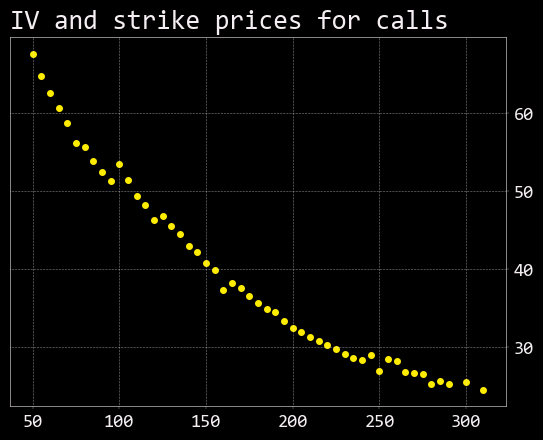

In [119]:
plt.scatter(strikes, vols)
plt.title("IV and strike prices for calls")

### compute the forward stock price using put-call parity
### set the expiration 
### assign a beta usually at 0.5

In [120]:
f = (
    (jan_2026_c.mid - jan_2026_p.mid)
    .dropna()
    .abs()
    .sort_values()
    .index[0]
)
t = (pd.Timestamp(expiration) - pd.Timestamp.now()).days / 365
beta = 0.5

###  instantiate the model and call fit to get alpha, rho, and volvol

In [121]:
#The fit method calibrates the SABR model parameters to best fit a given volatility smile. 
#The alpha parameter is a measure of the at-the-money volatility level, rho represents the correlation 
#between the asset price and its volatility, and volvol which is the volatility of volatility.

sabr_lognormal = Hagan2002LognormalSABR(
    f=f,
    t=t,
    beta=beta
)

alpha, rho, volvol = sabr_lognormal.fit(strikes, vols)

### calibrate the volatility smile

In [122]:
calibrated_vols = [
    sabr.lognormal_vol(strike, f, t, alpha, beta, rho, volvol) * 100
    for strike in strikes
]

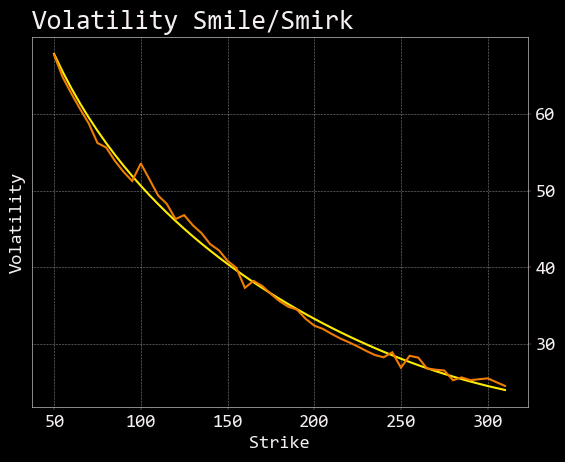

In [123]:
plt.plot(
    strikes, 
    calibrated_vols
)

plt.xlabel("Strike")
plt.ylabel("Volatility")
plt.title("Volatility Smile/Smirk")
plt.plot(strikes, vols)
plt.show()

In [132]:
t

2.1397260273972605

Text(0.0, 1.0, 'error for each strike price based on the calibrated\n implied volatility from the SABR model.')

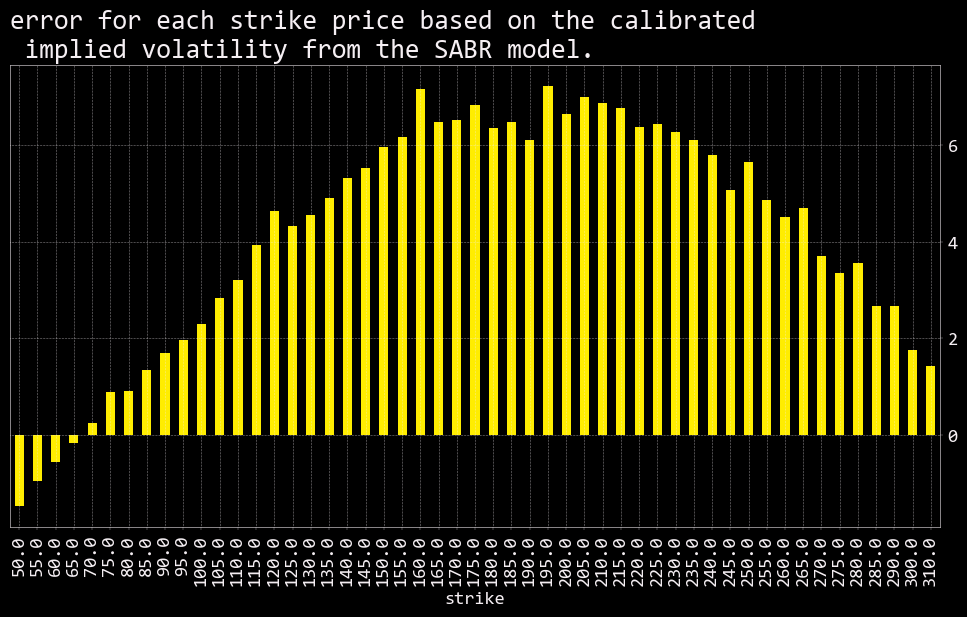

In [141]:
black_values = []
for strike, calibrated_vol in zip(strikes.tolist(), calibrated_vols):
    black_value = lognormal_call(
        strike, 
        f, 
        t, 
        calibrated_vol / 100, 
        0.05, 
        cp="call"
    )
    black_values.append(black_value)

option_values = pd.DataFrame(
    {
        "black": black_values,
        "market": jan_2026_c.mid
    },
    index=strikes
)
plt.figure(figsize=(12, 6))
(option_values.black - option_values.market).plot.bar()
plt.title('error for each strike price based on the calibrated\n implied volatility from the SABR model.')